In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam

# Load the dataset
file_path = "F:/FYP project/FYP(Flood)/Real Data/Flood_fyp_data.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Handle NaN values using forward-fill
data.fillna(method='ffill', inplace=True)

# Drop 'Date' and 'Hour' columns if they exist
data = data.drop(columns=['Date', 'Hour'], errors='ignore')

# Define input features (X) and target values (y)
X = data[['Discharge Rate (cumecs)', 'Rainfall Data (mm)', 'Water Level (m)']].values
y = data[['Next 1 Hour Water Level (m)', 'Next 2 Hours Water Level (m)', 'Next 3 Hours Water Level (m)']].values

# Normalize the input features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

# Reshape the data to be 3D for GRU input
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))  # 3D shape for GRU

# Split dataset into training (70%), validation (15%), and testing (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize the GRU model
model = Sequential()

# GRU layers
model.add(GRU(units=64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=3))  # 3 outputs (1st, 2nd, 3rd hour predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Predict on the test set
y_test_pred = model.predict(X_test)


Epoch 1/50


C:\Users\Janith\AppData\Local\Temp\ipykernel_14032\3043400326.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
c:\Users\Janith\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.8442 - val_loss: 1.8787
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1844 - val_loss: 0.2632
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2153 - val_loss: 0.1738
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1417 - val_loss: 0.1235
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1097 - val_loss: 0.0883
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0776 - val_loss: 0.0755
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0723 - val_loss: 0.0726
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0663 - val_loss: 0.0714
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0689 - val_loss: 0.0686
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0689 - val_loss: 0.0699
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0680 - val_loss: 0.0719
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.


Testing Results:
1st Hour Prediction Accuracy: 96.26%, MAE: 0.0696
2nd Hour Prediction Accuracy: 93.27%, MAE: 0.1332
3rd Hour Prediction Accuracy: 90.06%, MAE: 0.1938

Sample Predictions vs Actual Values:
   Actual 1st Hour  Predicted 1st Hour  Actual 2nd Hour  Predicted 2nd Hour  \
0             0.15            0.157122             0.17            0.169841   
1             0.77            0.775337             0.82            0.784156   
2             2.71            2.623996             2.81            2.652163   
3             1.80            1.877214             1.70            1.879237   
4             2.23            2.220954             2.18            2.220870   
5             0.26            0.272716             0.25            0.284703   
6             1.22            1.241879             1.22            1.247812   
7             3.34            3.301332             3.41            3.302524   
8             0.23            0.263077             0.22            0.275125   
9   

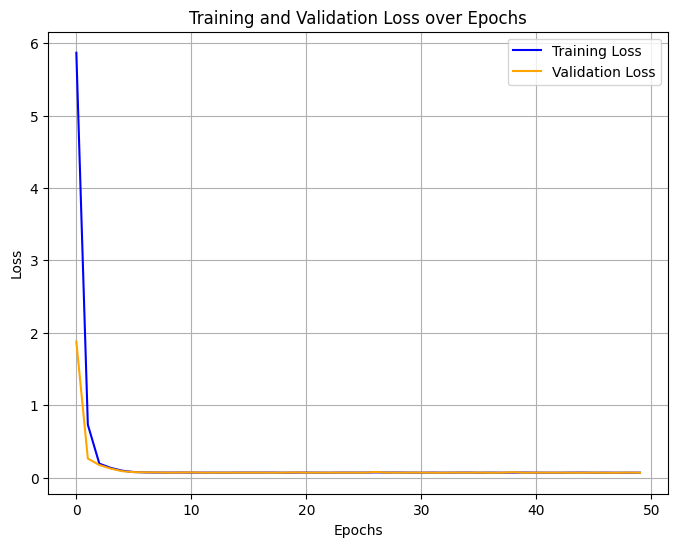

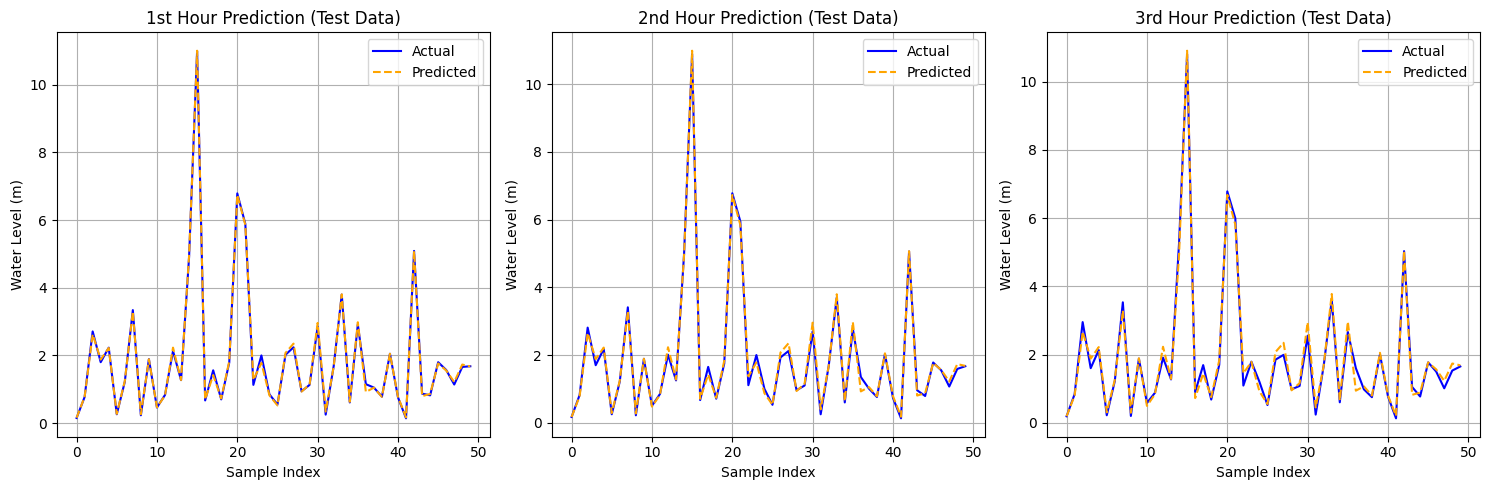

In [16]:
# Function to calculate accuracy as a percentage
def calculate_accuracy(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # MAPE in percentage
    accuracy = 100 - mape  # Accuracy in percentage
    return accuracy

# Calculate accuracy and MAE for each hour
accuracy_1st_hour = calculate_accuracy(y_test[:, 0], y_test_pred[:, 0])
mae_1st_hour = mean_absolute_error(y_test[:, 0], y_test_pred[:, 0])

accuracy_2nd_hour = calculate_accuracy(y_test[:, 1], y_test_pred[:, 1])
mae_2nd_hour = mean_absolute_error(y_test[:, 1], y_test_pred[:, 1])

accuracy_3rd_hour = calculate_accuracy(y_test[:, 2], y_test_pred[:, 2])
mae_3rd_hour = mean_absolute_error(y_test[:, 2], y_test_pred[:, 2])

# Print accuracies and MAE
print("\nTesting Results:")
print(f"1st Hour Prediction Accuracy: {accuracy_1st_hour:.2f}%, MAE: {mae_1st_hour:.4f}")
print(f"2nd Hour Prediction Accuracy: {accuracy_2nd_hour:.2f}%, MAE: {mae_2nd_hour:.4f}")
print(f"3rd Hour Prediction Accuracy: {accuracy_3rd_hour:.2f}%, MAE: {mae_3rd_hour:.4f}")

# Display some sample predictions vs actual values
print("\nSample Predictions vs Actual Values:")
sample_data = pd.DataFrame({
    'Actual 1st Hour': y_test[:, 0],
    'Predicted 1st Hour': y_test_pred[:, 0],
    'Actual 2nd Hour': y_test[:, 1],
    'Predicted 2nd Hour': y_test_pred[:, 1],
    'Actual 3rd Hour': y_test[:, 2],
    'Predicted 3rd Hour': y_test_pred[:, 2],
})
print(sample_data.head(10))

# Visualization: Training loss vs Validation loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Visualization: True vs Predicted values for all 3 targets
plt.figure(figsize=(15, 5))
for i, target in enumerate(['1st Hour', '2nd Hour', '3rd Hour']):
    plt.subplot(1, 3, i+1)
    plt.plot(y_test[:50, i], label='Actual', color='blue')
    plt.plot(y_test_pred[:50, i], label='Predicted', color='orange', linestyle='--')
    plt.title(f'{target} Prediction (Test Data)')
    plt.xlabel('Sample Index')
    plt.ylabel('Water Level (m)')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()


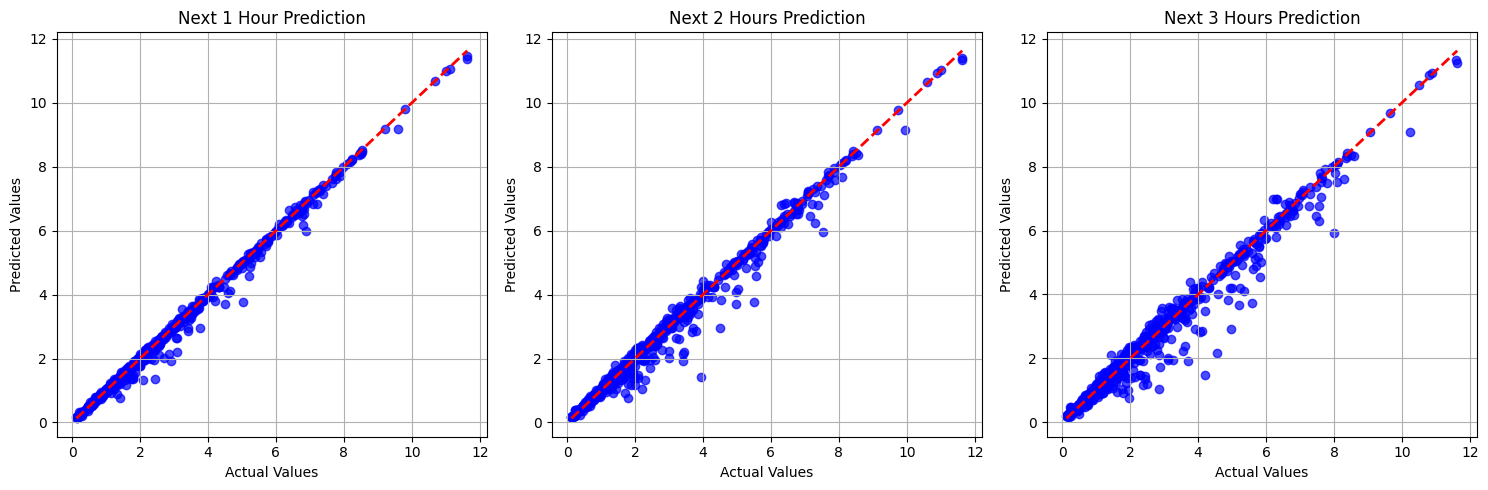

In [9]:
# Visualization: True vs Predicted values for all 3 targets
plt.figure(figsize=(15, 5))
for i, target in enumerate(['Next 1 Hour', 'Next 2 Hours', 'Next 3 Hours']):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test[:, i], y_test_pred[:, i], alpha=0.7, color='blue')
    plt.plot([min(y_test[:, i]), max(y_test[:, i])], 
             [min(y_test[:, i]), max(y_test[:, i])], 
             color='red', linestyle='--', linewidth=2)  # Ideal line
    plt.title(f'{target} Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
plt.tight_layout()
plt.show()